In [3]:
from src.data.evaluation import ocr_metrics
from src.data.generator import DataGenerator
from src.network.model import HTRModel
from rest.clients import groq_client 

In [4]:
from dotenv import load_dotenv
import os
load_dotenv()

GROQ_API_KEYS=os.getenv("GROQ_API_KEYS", "[]")
GROQ_API_KEYS = [key.removeprefix('"').removesuffix('"') for key in GROQ_API_KEYS.removeprefix('[').removesuffix(']').split(",")]

In [5]:
source_path="./data/mine_logs.hdf5"
batch_size=16
charset_base="""0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ČčĆćĐđŽžŠš"""
max_text_length=256
predict=True
architecture="flor"
input_size=(1024, 128, 1)
vocab_size=110
beam_width=30
reduce_tolerance=20
stop_tolerance=30
target_path="./ml_models/text_detection_model.hdf5"

In [6]:
dtgen = DataGenerator(source=source_path,
                              batch_size=batch_size,
                              charset=charset_base,
                              max_text_length=max_text_length,
                              predict=True)

model = HTRModel(architecture=architecture,
                         input_size=input_size,
                         vocab_size=dtgen.tokenizer.vocab_size,
                         beam_width=30,
                         top_paths=10,
                         )


model.compile(learning_rate=0.001)
model.load_checkpoint(target=target_path)

In [7]:
import datetime
import asyncio

async def test(ds="test", groq_model: str = None, fuel_shot_size: int = 50, groq_threshold: float = 1.0):
    """
    ds: vals "test", "valid", "train"
    """
    start_time = datetime.datetime.now()

    predicts, probability = model.predict(x=dtgen.next_test_batch(),
                                steps=dtgen.steps[ds],
                                ctc_decode=True)
    predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
    ground_truth = [x.decode() for x in dtgen.dataset[ds]['gt']]
    
    if groq_model:
        probability = [y[0] for y in probability]
        predicts = [el for el in list(zip(predicts,probability))]
        client = groq_client.GroqClient(groq_model, GROQ_API_KEYS, fuel_shot_size)
        predicts = [asyncio.create_task(client.correct_extraction(x[0])) if x[1] <= groq_threshold else x[0] for x in predicts]
        await asyncio.gather(*[x for x in predicts if not isinstance(x, str)])
        predicts = [x if isinstance(x, str) else x.result() for x in predicts]

    
    total_time = datetime.datetime.now() - start_time
    evaluate = ocr_metrics(predicts=predicts, ground_truth=ground_truth)

    e_corpus = "\n".join([
        f"Total test images:    {dtgen.size[ds]}",
        f"Total time:           {total_time}",
        f"Time per item:        {total_time / dtgen.size[ds]}\n",
        "Metrics:",
        f"Character Error Rate: {evaluate[0]:.8f}",
        f"Word Error Rate:      {evaluate[1]:.8f}",
        f"Sequence Error Rate:  {evaluate[2]:.8f}"
    ])
    print(e_corpus)
    with open("val_test.csv", "a") as wf:
        wf.write(f"{datetime.datetime.now().isoformat()},{groq_model},{dtgen.size[ds]},{total_time},{total_time / dtgen.size[ds]},{evaluate[0]:.8f},{evaluate[1]:.8f},{evaluate[2]:.8f},{fuel_shot_size},{groq_threshold:.4f}\n")


# NO LLM

In [10]:
await test()

Total test images:    111
Total time:           0:02:02.324109
Time per item:        0:00:01.102019

Metrics:
Character Error Rate: 0.14501020
Word Error Rate:      0.34817858
Sequence Error Rate:  0.66666667


# llama3-8b-8192

In [7]:
await test(groq_model="llama3-8b-8192", groq_threshold=0.5)

Total test images:    111
Total time:           0:02:26.676579
Time per item:        0:00:01.321411

Metrics:
Character Error Rate: 0.17439113
Word Error Rate:      0.31745804
Sequence Error Rate:  0.54954955


In [8]:
await test(groq_model="llama3-8b-8192")

Total test images:    111
Total time:           0:06:54.108271
Time per item:        0:00:03.730705

Metrics:
Character Error Rate: 0.21273296
Word Error Rate:      0.34230271
Sequence Error Rate:  0.63063063


# llama3-70b-8192

In [9]:
await test(groq_model="llama3-70b-8192", groq_threshold=0.5)

Total test images:    111
Total time:           0:05:26.804368
Time per item:        0:00:02.944183

Metrics:
Character Error Rate: 0.12315991
Word Error Rate:      0.24478633
Sequence Error Rate:  0.51351351


In [10]:
await test(groq_model="llama3-70b-8192")

Total test images:    111
Total time:           0:29:20.612875
Time per item:        0:00:15.861377

Metrics:
Character Error Rate: 0.17103373
Word Error Rate:      0.29108714
Sequence Error Rate:  0.60360360


# mixtral-8x7b-32768	

In [12]:
await test(groq_model="mixtral-8x7b-32768", groq_threshold=0.5)

InternalServerError: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}

In [ ]:
await test(groq_model="mixtral-8x7b-32768")

# gemma-7b-it

In [13]:
await test(groq_model="gemma-7b-it", groq_threshold=0.5)

Total test images:    111
Total time:           0:06:28.377431
Time per item:        0:00:03.498896

Metrics:
Character Error Rate: 0.66371335
Word Error Rate:      0.70506803
Sequence Error Rate:  0.77477477


In [14]:
await test(groq_model="gemma-7b-it")

Total test images:    111
Total time:           0:09:47.419875
Time per item:        0:00:05.292071

Metrics:
Character Error Rate: 0.96349016
Word Error Rate:      0.99043091
Sequence Error Rate:  1.00000000


# gemma2-9b-it

In [16]:
await test(groq_model="gemma2-9b-it", groq_threshold=0.5)

Total test images:    111
Total time:           0:03:57.031107
Time per item:        0:00:02.135415

Metrics:
Character Error Rate: 0.19478908
Word Error Rate:      0.29265311
Sequence Error Rate:  0.77477477


In [17]:
await test(groq_model="gemma2-9b-it")

Total test images:    111
Total time:           0:09:30.087623
Time per item:        0:00:05.135925

Metrics:
Character Error Rate: 0.24965632
Word Error Rate:      0.31797765
Sequence Error Rate:  1.00000000


# Results:

In [122]:
data = []

with open("./val_test.csv", "r") as rf:
    head = rf.readline()
    head = head.split(",")
    while line := rf.readline():
        line = line.split(",")
        data_zip = {k.removesuffix("\n"): v.removesuffix("\n") for k, v in list(zip(head, line))}
        data.append(data_zip)


In [123]:
x_labels = [f'{i["MODEL_NAME"]}-{i["FUEL_SHOT_SIZE"]}-{i["GROQ_THRESHOLD"]:.3}' for i in data]
y_values_cer = [float(i["CER"]) for i in data]
y_values_wer = [float(i["WER"]) for i in data]
y_values_ser = [float(i["SER"]) for i in data]

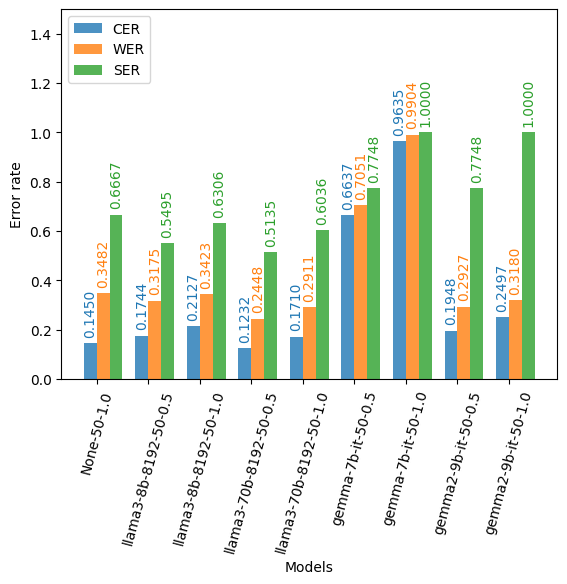

In [125]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = x_labels
group1_values = y_values_cer
group2_values = y_values_wer
group3_values = y_values_ser


colors_group1 = '#1f77b4'  # Blue
colors_group2 = '#ff7f0e'  # Orange
colors_group3 = '#2ca02c'  # Green

fig, ax = plt.subplots()
n_groups = len(x_labels)
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

bars1 = ax.bar(index, group1_values, bar_width, alpha=opacity, color=[colors_group1], label='CER')
bars2 = ax.bar(index + bar_width, group2_values, bar_width, alpha=opacity, color=[colors_group2], label='WER')
bars3 = ax.bar(index + 2*bar_width, group3_values, bar_width, alpha=opacity, color=[colors_group3], label='SER')

ax.set_xlabel('Models')
ax.set_ylabel('Error rate')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(x_labels, rotation=75)
ax.legend()

ax.set_ylim(0, 1.5)

for bar, label, value in zip(bars1, x_labels, group1_values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.025, f'{value:.4f}', 
            ha='center', va='bottom', color=colors_group1, rotation=90)
            
for bar, label, value in zip(bars2, x_labels, group2_values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.025, f'{value:.4f}', 
            ha='center', va='bottom', color=colors_group2, rotation=90)
    
for bar, label, value in zip(bars3, x_labels, group3_values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.025, f'{value:.4f}', 
            ha='center', va='bottom', color=colors_group3, rotation=90)
            
plt.show()
